In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.text import TextPath
from matplotlib.patches import FancyArrowPatch, Circle, PathPatch, Wedge
from matplotlib.transforms import Affine2D
from mpl_toolkits.mplot3d import Axes3D, art3d, proj3d

In [2]:
# adapted from the link below in order to transform 2d patches to arbitrary normals in 3d
# https://stackoverflow.com/questions/18228966/how-can-matplotlib-2d-patches-be-transformed-to-3d-with-arbitrary-normals?noredirect=1&lq=1

def rotation_matrix(d):
    """
    Calculates a rotation matrix given a vector d. The direction of d
    corresponds to the rotation axis. The length of d corresponds to 
    the sin of the angle of rotation.

    Variant of: http://mail.scipy.org/pipermail/numpy-discussion/2009-March/040806.html
    """
    sin_angle = np.linalg.norm(d)

    if sin_angle == 0:
        return np.identity(3)

    d /= sin_angle
    eye = np.eye(3)
    ddt = np.outer(d, d)
    skew = np.array([[    0,  d[2],  -d[1]],
                     [-d[2],     0,   d[0]],
                     [ d[1], -d[0],     0]], dtype=np.float64)

    M = ddt + np.sqrt(1 - sin_angle**2) * (eye - ddt) + sin_angle * skew
    return M

def pathpatch_2d_to_3d(pathpatch, z = 0, normal = 'z'):
    """
    Transforms a 2D Patch to a 3D patch using the given normal vector.

    The patch is projected into they XY plane, rotated about the origin
    and finally translated by z.
    """
    if type(normal) is str: #Translate strings to normal vectors
        index = "xyz".index(normal)
        normal = np.roll((1.0,0,0), index)

    normal /= np.linalg.norm(normal) #Make sure the vector is normalised

    path = pathpatch.get_path() #Get the path and the associated transform
    trans = pathpatch.get_patch_transform()

    path = trans.transform_path(path) #Apply the transform

    pathpatch.__class__ = art3d.PathPatch3D #Change the class
    pathpatch._code3d = path.codes #Copy the codes
    pathpatch._facecolor3d = pathpatch.get_facecolor #Get the face color    

    verts = path.vertices #Get the vertices in 2D

    d = np.cross(normal, (0, 0, 1)) #Obtain the rotation vector    
    M = rotation_matrix(d) #Get the rotation matrix

    pathpatch._segment3d = np.array([np.dot(M, (x, y, 0)) + (0, 0, z) for x, y in verts])

def pathpatch_translate(pathpatch, delta):
    """
    Translates the 3D pathpatch by the amount delta.
    """
    pathpatch._segment3d += delta

In [3]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

def textpath(s, color, alpha=1, size=2, angle=0, usetex=True, scalex=1, scaley=1):
    text_path = TextPath((0, 0), s, usetex=usetex, size=size)
    trans = Affine2D().scale(sx=scalex,sy=scaley).rotate(angle)
    p = PathPatch(trans.transform_path(text_path), color=color, alpha=alpha)
    return p
     
def text3d(ax, xyz, s, color, alpha=1, normal="z", size=1, angle=0, usetex=True, scalex=1, scaley=1):
    x, y, z = xyz
    path = textpath(s, color, alpha, size, angle, usetex, scalex, scaley)
    ax.add_patch(path)
    pathpatch_2d_to_3d(path, z = 0, normal = normal)
    pathpatch_translate(path, (x,y,z))

In [4]:
# There exist a bug in mpl_toolkits when projecting in 3d with equal aspects. In the latest version
# of matplotlib (3.1) the possibility of setting aspects equal is removed temporarily. 
# We use a hack that rescales some lenghts which eventually leads to visually equal aspects.
# For more details about the issue, look at the link below:
# https://github.com/matplotlib/matplotlib/issues/1077/

class Coorcylind():
    def __init__(self,r,t,z, margin=0.2):
        # geometrical parameters
        self.r = r
        self.t = t
        self.z = z
        self.x = r*np.cos(t)
        self.y = r*np.sin(t)
        
        # config parameters - used in plotting
        self.margin = 0.1 # the margin between texts or borders and vector tips
        self.dr = self.margin/2 
        self.dt = 0.125
        self.dz = self.dr
        self.text_size_basis = 1
        
        # the length of basis vectors
        self._len = None
        self._lenz= None
        
    def draw_projection(self, x, y, z, ax, linewidth=2, style_color = '--b'):
        # projections on surfaces
        endpoints = [([x, x],[y, y],[z, 0])]
        endpoints.append(([x, x],[y, 0],[0, 0]))
        endpoints.append(([x, 0],[y, y],[0, 0]))
        endpoints.append(([x, 0],[y, 0],[z, z]))
        endpoints.append(([x, 0],[y, 0],[0, 0]))

        for endpoint in endpoints:
            ax.plot(endpoint[0],endpoint[1],endpoint[2], style_color, linewidth=linewidth)
        ax.scatter([x,0,0,x],[0,y,0,y],[0,0,z,0],color=style_color[-1])
    
    def draw_axis(self, r,z, ax,margin):
        #ploting the axis x,y, z
        x_axis = Arrow3D([0, r*(1+2*margin)], [0, 0],[0, 0], mutation_scale=20, lw=1, arrowstyle="-|>", color="k",)
        y_axis = Arrow3D([0, 0], [0, r*(1+2*margin)],[0, 0], mutation_scale=20, lw=1, arrowstyle="-|>", color="k")
        z_axis = Arrow3D([0, 0], [0, 0],[0, z*(1+2*margin)], mutation_scale=20, lw=1, arrowstyle="-|>", color="k")
        ax.add_artist(x_axis)
        ax.add_artist(y_axis)
        ax.add_artist(z_axis)
    
    def draw_basis(self, x,y,z,t, ax):
        # a hack to fix the matplotlib z-scale problem in 3D
        _len = ax.get_xlim()[1]*0.3
        _lenz  = _len* min(1, ax.get_zlim()[1]/ax.get_xlim()[1]*.5)
        self._len = _len
        self._lenz = _lenz
        
        # Cartesian basis vectors
        e_i = Arrow3D([0,1*_len],[0,0],[0,0], lw=2, mutation_scale=10,arrowstyle="-|>", color="purple")
        e_j = Arrow3D([0,0],[0,1*_len],[0,0], lw=2, mutation_scale=10,arrowstyle="-|>", color="purple")
        e_k = Arrow3D([0,0],[0,0],[0,1*_lenz], lw=2, mutation_scale=10,arrowstyle="-|>", color="purple")
        ax.add_artist(e_i)
        ax.add_artist(e_j)
        ax.add_artist(e_k)

        # Cylindrical basis vectors
        e_r = Arrow3D([x, x+np.cos(t)*_len], [y, y+np.sin(t)*_len],[z, z], mutation_scale=10,lw=2, arrowstyle="-|>", color="purple")
        e_t = Arrow3D([x, x-np.sin(t)*_len], [y, y+np.cos(t)*_len],[z, z], mutation_scale=10,lw=2, arrowstyle="-|>", color="purple")
        e_z = Arrow3D([x, x], [y, y],[z, z+1*_lenz],mutation_scale=10, lw=2, arrowstyle="-|>", color="purple")
        ax.add_artist(e_r)
        ax.add_artist(e_t)
        ax.add_artist(e_z)

    def draw_vector(self, x,y,z, ax):
        xs = [0, x]
        ys = [0, y]
        zs = [0, z]
        vec = Arrow3D(xs,ys,zs, color='b', mutation_scale=5, lw=2, arrowstyle="-|>", alpha=0.7)
        ax.add_artist(vec)

    def draw_angle(self, r,t, ax):
        # plots the wedge associated with the angle
        angle = Wedge((0, 0), r/6., 0, t*180/np.pi, color='g')
        ax.add_patch(angle)
        art3d.pathpatch_2d_to_3d(angle, z=0, zdir='z')
        
    def draw_cylinder(self, r,z,ax):
        # Making cylinderical surface
        N=30
        Z = np.linspace(0,z*(1+self.margin),10)
        theta = np.linspace(0,2*np.pi,N)
        X= r*np.sin(theta)
        Y= r*np.cos(theta)
        ax.plot_surface(X, Y, np.outer(Z,np.ones_like(theta)), alpha=0.2,shade=False)

        # plotting the circles
        plt.plot(X,Y,X*0,'-k',linewidth=1, )
        circle = Circle((0, 0), r, facecolor='b', alpha=0.15)
        ax.add_patch(circle)
        art3d.pathpatch_2d_to_3d(circle, z=z, zdir='z')
    
    def draw_surface_element(self, t, r, z, ax ):
        N=30
        dr = 0.1*r
        dt = self.dt
        dz = dr
        
        # a hack for proper length due to matplotlib's 3d projection bug
        dz *= min(1,ax.get_zlim()[1]/ax.get_xlim()[1]*.5 )

        Z = np.linspace(z,z+dz,N)
        theta = np.linspace(t,t+dt,N)
        X= r*np.cos(theta)
        Y= r*np.sin(theta)
        ax.plot_surface(X, Y, np.outer(Z,np.ones_like(theta)), alpha=0.8,shade=False, )
        
        x = r*np.cos(t)
        y = r*np.sin(t)
        ax.plot([x, x],[y, y], [z,z+dz], '-r', linewidth=2, marker='.', markersize=3)
        ax.plot([r*np.cos(t+dt), r*np.cos(t+dt)],[r*np.sin(t+dt), r*np.sin(t+dt)], [z,z+dz], '-r', linewidth=2, marker='.', markersize=3)
        ax.plot([x, r*np.cos(t+dt)],[y, r*np.sin(t+dt)], [z,z], '-r', linewidth=2, marker='.', markersize=3)
        ax.plot([x, r*np.cos(t+dt)],[y, r*np.sin(t+dt)], [z+dz,z+dz], '-r', linewidth=2, marker='.', markersize=3)
        
        # differential projections
        ax.plot([0, r*np.cos(t+dt)],[0, r*np.sin(t+dt)], [z,z], '--r', linewidth=1)
        ax.plot([0, r*np.cos(t+dt)],[0, r*np.sin(t+dt)], [z+dz,z+dz], '--r', linewidth=1)
        ax.plot([0, x],[0, y], [z,z], '--r', linewidth=1)
        ax.plot([0, x],[0, y], [z+dz,z+dz], '--r', linewidth=1)
        ax.plot([0, r*np.cos(t+dt)],[0, r*np.sin(t+dt)], [0,0], '--r', linewidth=1)
        ax.plot([r*np.cos(t+dt), r*np.cos(t+dt)],[r*np.sin(t+dt), r*np.sin(t+dt)], [0,z],'--r', linewidth=1)
        ax.plot([x, x],[y, y], [z,0], '--r', linewidth=1)
        
    def draw_volume_element(self, t, r, x,y,z, ax ):
        N=30
        dr = 0.1*r
        dt = self.dt
        dz = dr
        
        # a hack for proper length due to matplotlib's 3d projection bug
        dz *= min(1,ax.get_zlim()[1]/ax.get_xlim()[1]*.5 )

        ## faces
        # face 1: curved faces
        Z = np.linspace(z,z+dz,N)
        theta = np.linspace(t,t+dt,N)
        X= r*np.cos(theta)
        Y= r*np.sin(theta)
        ax.plot_surface(X, Y, np.outer(Z,np.ones_like(theta)), alpha=0.2,shade=False, color='r')

        # face 2: curved faces
        X= (r+dr)*np.cos(theta)
        Y= (r+dr)*np.sin(theta)
        ax.plot_surface(X, Y, np.outer(Z,np.ones_like(theta)), alpha=0.2,shade=False,color='r')
        
        # face 3: straight faces
        R = np.linspace(r,r+dr,N)
        X= R*np.cos(t)
        Y= R*np.sin(t)
        ax.plot_surface(X, Y, np.outer(Z,np.ones_like(R)), alpha=0.2,shade=False,color='r')
        
        # face 4: straight faces
        X= R*np.cos(t+dt)
        Y= R*np.sin(t+dt)
        ax.plot_surface(X, Y, np.outer(Z,np.ones_like(R)), alpha=0.2,shade=False,color='r')
        
        # face 5: straight faces
        X= np.outer(R,np.cos(theta))
        Y= np.outer(R,np.sin(theta))
        ax.plot_surface(X, Y, z*np.ones_like(X), alpha=0.2,shade=False,color='r')
        
        # face 6: straight faces
        ax.plot_surface(X, Y, (z+dz)*np.ones_like(X), alpha=0.2,shade=False,color='r')
        
        ## lines
        ax.plot([x, x+dr*np.cos(t)],[y, y+dr*np.sin(t)], [z,z], '-r', linewidth=2, marker='.', markersize=3)
        ax.plot([x, x+dr*np.cos(t)],[y, y+dr*np.sin(t)], [z+dz,z+dz], '-r', linewidth=2, marker='.', markersize=3)
        ax.plot([x, r*np.cos(t+dt)],[y, r*np.sin(t+dt)], [z,z], '-r', linewidth=2, marker='.', markersize=3)
        ax.plot([x, r*np.cos(t+dt)],[y, r*np.sin(t+dt)], [z+dz,z+dz], '-r', linewidth=2, marker='.', markersize=3)
        ax.plot([x+dr*np.cos(t), (r+dr)*np.cos(t+dt)],[y+dr*np.sin(t), (r+dr)*np.sin(t+dt)], [z,z], '-r', linewidth=2, marker='.', markersize=3)
        ax.plot([x+dr*np.cos(t), (r+dr)*np.cos(t+dt)],[y+dr*np.sin(t), (r+dr)*np.sin(t+dt)], [z+dz,z+dz], '-r', linewidth=2, marker='.', markersize=3)
        ax.plot([x, x],[y, y], [z,z+dz], '-r', linewidth=2, marker='.', markersize=3)
        ax.plot([r*np.cos(t+dt), r*np.cos(t+dt)],[r*np.sin(t+dt), r*np.sin(t+dt)], [z,z+dz], '-r', linewidth=2, marker='.', markersize=3)
        ax.plot([(r+dr)*np.cos(t+dt), (r+dr)*np.cos(t+dt)],[(r+dr)*np.sin(t+dt), (r+dr)*np.sin(t+dt)], [z,z+dz], '-r', linewidth=2, marker='.', markersize=3)
        ax.plot([(r+dr)*np.cos(t), (r+dr)*np.cos(t)],[(r+dr)*np.sin(t), (r+dr)*np.sin(t)], [z,z+dz], '-r', linewidth=2, marker='.', markersize=3)
        ax.plot([r*np.cos(t+dt), r*np.cos(t+dt)+dr*np.cos(t+dt)],[r*np.sin(t+dt), r*np.sin(t+dt)+dr*np.sin(t+dt)], [z,z], '-r', linewidth=2)
        ax.plot([r*np.cos(t+dt), r*np.cos(t+dt)+dr*np.cos(t+dt)],[r*np.sin(t+dt), r*np.sin(t+dt)+dr*np.sin(t+dt)], [z+dz,z+dz], '-r', linewidth=2)

        # differential projections
        ax.plot([0, r*np.cos(t+dt)],[0, r*np.sin(t+dt)], [z,z], '--r', linewidth=1)
        ax.plot([0, r*np.cos(t+dt)],[0, r*np.sin(t+dt)], [z+dz,z+dz], '--r', linewidth=1)
        ax.plot([0, x],[0, y], [z,z], '--r', linewidth=1)
        ax.plot([0, x],[0, y], [z+dz,z+dz], '--r', linewidth=1)
        ax.plot([0, r*np.cos(t+dt)],[0, r*np.sin(t+dt)], [0,0], '--r', linewidth=1)
        ax.plot([r*np.cos(t+dt), r*np.cos(t+dt)],[r*np.sin(t+dt), r*np.sin(t+dt)], [z,0], '--r', linewidth=1)
        ax.plot([x, x],[y, y], [z,0], '--r', linewidth=1)
        
        
    def texts(self, x,y,z,r,t,margin, ax):
        scalex = min(1, .75*ax.get_zlim()[1]/ax.get_xlim()[1])
        scaley = min(1, .75*ax.get_zlim()[1]/ax.get_xlim()[1])
        
        # axis texts
        text3d(ax, (r*(1+2*margin), 0, 0), "$X$", color="k", normal="z")
        text3d(ax, (0, r*(1+2*margin), 0), "$Y$", color="k", normal="z")
        text3d(ax, (0, 0, z*(1+2*margin)), "$Z$", color="k", normal=(0,-1,0), scaley=scaley)
        
        # xyz texts
        text3d(ax, (x/2, -r*2*margin, 0), "$x$", color="b", normal="z")
        text3d(ax, (-r*2*margin, y/2, 0), "$y$", color="b", normal="z")
        text3d(ax, (x*(1+margin/2), y*(1+margin/2), z/2), "$z$", color="b", normal=(np.sin(t),-np.cos(t),0), angle= t, scaley=scaley )
               
        # r-theta texts
        text3d(ax, (r*(1+margin)/6*np.cos(t/2), r*(1+margin)/6*np.sin(t/2),0), r"$\theta$", color="g", normal='z')
        text3d(ax, (r/2*np.cos(t), r/2*np.sin(t), 0), r"$\rho$", color="g", normal='z')
                
        #vect text
        xyz = np.array([x,y,z*(1+margin)])/2
        text3d(ax, (x/2, y/2, z/2), "$R$", color="b", normal=(np.sin(t),-np.cos(t),0), angle= t, scaley=scaley )
        
        # clynderical basis vects
        text3d(ax, (x+self._len*np.cos(t), y+self._len*np.sin(t), z), r"$e_r$", color="purple", normal=(np.sin(t),-np.cos(t),0), angle= t, scaley=scaley )
        text3d(ax, (x-self._len*np.sin(t), y+self._len*np.cos(t), z),r"$e_{\theta}$", color="purple", normal=(np.cos(t),np.sin(t),-0) , angle=t+np.pi/2, scaley=scaley)
        text3d(ax, (x, y, z+self._lenz), r"$e_z$", color="purple", normal=(np.sin(t),-np.cos(t),0), angle= t, scaley=scaley  )

    def plot(self, draw_surface=False, draw_volume=True):
        fig = plt.figure(figsize=(6,6))
        ax = fig.gca(projection='3d',)

        # setting the figure limits
        ax.set_zlim(0, self.z*(1+3*self.margin))
        ax.set_xlim(-self.r*(1+4*self.margin), self.r*(1+4*self.margin))
        ax.set_ylim(-self.r*(1+4*self.margin), self.r*(1+4*self.margin))
        
        # plotting
        self.draw_cylinder(self.r,self.z, ax)
        self.draw_axis(self.r, self.z, ax, self.margin)
        self.draw_basis(self.x, self.y, self.z, self.t, ax)
        self.draw_vector(self.x, self.y, self.z,ax)
        self.draw_angle(self.r,self.t,ax)
        self.texts(self.x,self.y,self.z,self.r,self.t,self.margin, ax)
        self.draw_projection(self.x, self.y, self.z, ax, linewidth=0.5, style_color = '--b')
        if draw_volume:
            self.draw_volume_element(self.t, self.r, self.x, self.y, self.z, ax)
        elif draw_surface:
            self.draw_surface_element(self.t, self.r, self.z, ax)
        plt.show()
        

In [5]:
r = 5
theta = np.pi/3
z = 1

C = Coorcylind(r,theta,z)

<IPython.core.display.Javascript object>


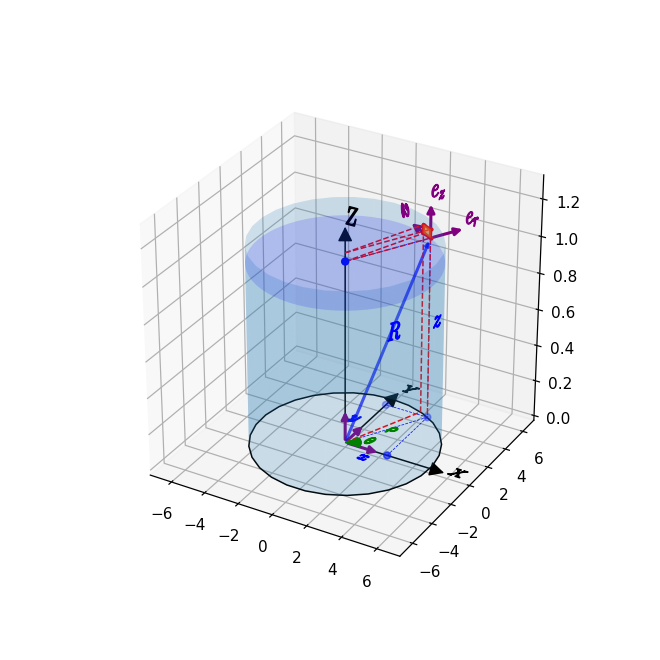

In [6]:
C.plot(draw_surface=True, draw_volume=False)